In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import utils
import pandas as pd

2022-03-23 14:02:23.833572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 14:02:23.833638: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#MAIN_PATH = "/mnt/homeGPU/fcastro/MINDAT_AVAN/fran/"
MAIN_PATH = "/home/franblue/PROYECTOS/lulc/"

#data_dir = "../reduced_data/"
data_dir = MAIN_PATH + "data/"
batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_data, train_labels, test_data, test_labels, test_names = utils.load_data(data_dir, norm=False)

In [4]:
idx = np.logical_or(train_labels==20, train_labels==21)
train_data = train_data[idx]/255.0
train_labels = train_labels[idx]

idx = np.logical_or(test_labels==20, test_labels==21)
test_data = test_data[idx]/255.0
test_labels = test_labels[idx]

In [5]:
fl_train_data = train_data.reshape(train_data.shape[0], -1)
fl_test_data = test_data.reshape(test_data.shape[0], -1)

In [6]:
pca = PCA(n_components=100)
#pca = KernelPCA(kernel="poly", degree=3)

pca = pca.fit(fl_train_data)

In [7]:
n_components = 10
#sum(pca.eigenvalues_[0:n_components])/sum(pca.eigenvalues_)
np.sum(pca.explained_variance_ratio_[0:n_components])

0.9854722764316294

In [8]:
fl_train_data_trans = pca.transform(fl_train_data)[:,0:n_components]
fl_test_data_trans = pca.transform(fl_test_data)[:,0:n_components]

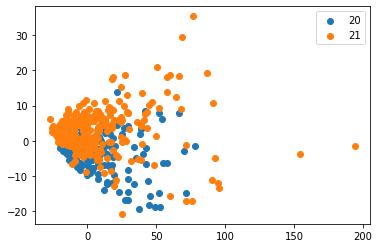

In [9]:
idx_20 = train_labels==20
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(fl_train_data_trans[idx_20,0], fl_train_data_trans[idx_20,1], label="20")
idx_21 = train_labels==21
ax.scatter(fl_train_data_trans[idx_21,0], fl_train_data_trans[idx_21,1], label="21")
plt.legend()

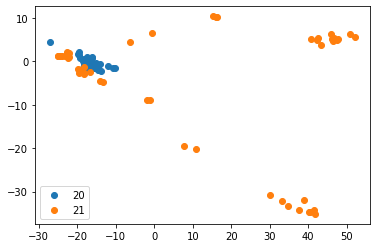

In [10]:
idx_20 = test_labels==20
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(fl_test_data_trans[idx_20,0], fl_test_data_trans[idx_20,1], label="20")
idx_21 = test_labels==21
ax.scatter(fl_test_data_trans[idx_21,0], fl_test_data_trans[idx_21,1], label="21")
plt.legend()

In [11]:
param_dic = {"C" : [0.0001, 0.001, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 10.0], "gamma" : [0.0001, 0.001, 0.1, 1.0, 2.0, 5.0]}

param_grid = ParameterGrid(param_dic)

In [12]:
svm = SVC(kernel="rbf")
gs = GridSearchCV(svm, param_dic)
gs = gs.fit(fl_train_data_trans, train_labels)

In [13]:
print(gs.best_params_)
print(gs.best_score_)

{'C': 3.0, 'gamma': 0.001}
0.7612326440914993


In [14]:
svm = SVC(C=gs.best_params_["C"], kernel="rbf", gamma=gs.best_params_["gamma"])
#svm = SVC(C=10.0, kernel="rbf", gamma=0.1)
svm = svm.fit(fl_train_data_trans, train_labels)

In [15]:
train_preds = svm.predict(fl_train_data_trans)
print(classification_report(train_labels, train_preds))

              precision    recall  f1-score   support

          20       0.74      0.84      0.79       354
          21       0.82      0.71      0.76       354

    accuracy                           0.78       708
   macro avg       0.78      0.78      0.77       708
weighted avg       0.78      0.78      0.77       708



In [16]:
test_preds = svm.predict(fl_test_data_trans)
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

          20       0.74      0.87      0.80        52
          21       0.83      0.69      0.75        51

    accuracy                           0.78       103
   macro avg       0.79      0.78      0.77       103
weighted avg       0.79      0.78      0.77       103



In [17]:
acc_train_list = []
acc_test_list = []
for d in param_grid:
    svm = SVC(C=d["C"], kernel="rbf", gamma=d["gamma"])
    svm = svm.fit(fl_train_data_trans, train_labels)
    train_preds = svm.predict(fl_train_data_trans)
    acc_train = accuracy_score(train_labels, train_preds)
    test_preds = svm.predict(fl_test_data_trans)
    acc_test = accuracy_score(test_labels, test_preds)
    print(f"C={d['C']}, gamma={d['gamma']}, acc_train={acc_train}, acc_test={acc_test}")

C=0.0001, gamma=0.0001, acc_train=0.5423728813559322, acc_test=0.6213592233009708
C=0.0001, gamma=0.001, acc_train=0.5918079096045198, acc_test=0.7184466019417476
C=0.0001, gamma=0.1, acc_train=0.6949152542372882, acc_test=0.883495145631068
C=0.0001, gamma=1.0, acc_train=0.6313559322033898, acc_test=0.7961165048543689
C=0.0001, gamma=2.0, acc_train=0.635593220338983, acc_test=0.7669902912621359
C=0.0001, gamma=5.0, acc_train=0.9717514124293786, acc_test=0.7184466019417476
C=0.001, gamma=0.0001, acc_train=0.5423728813559322, acc_test=0.6213592233009708
C=0.001, gamma=0.001, acc_train=0.5918079096045198, acc_test=0.7184466019417476
C=0.001, gamma=0.1, acc_train=0.6949152542372882, acc_test=0.883495145631068
C=0.001, gamma=1.0, acc_train=0.6313559322033898, acc_test=0.7961165048543689
C=0.001, gamma=2.0, acc_train=0.635593220338983, acc_test=0.7669902912621359
C=0.001, gamma=5.0, acc_train=0.9717514124293786, acc_test=0.7184466019417476
C=0.1, gamma=0.0001, acc_train=0.5437853107344632, a

In [18]:
svm = SVC(C=10.0, kernel="rbf", gamma=0.1)
svm = svm.fit(fl_train_data_trans, train_labels)

In [19]:
train_preds = svm.predict(fl_train_data_trans)
print(classification_report(train_labels, train_preds))

              precision    recall  f1-score   support

          20       0.93      0.95      0.94       354
          21       0.95      0.93      0.94       354

    accuracy                           0.94       708
   macro avg       0.94      0.94      0.94       708
weighted avg       0.94      0.94      0.94       708



In [20]:
test_preds = svm.predict(fl_test_data_trans)
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

          20       0.86      0.96      0.91        52
          21       0.96      0.84      0.90        51

    accuracy                           0.90       103
   macro avg       0.91      0.90      0.90       103
weighted avg       0.91      0.90      0.90       103

